In [16]:
%pip install pandas statsmodels matplotlib

Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
# Calculating forecast accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

In [18]:
# Load your data
# Assuming you have a CSV file with columns: 'date', 'dengue_patient_count', 'precipitation', 'wind_speed', 'temperature'
original_df = pd.read_csv('Kandy_df.csv', parse_dates=['Date'], index_col='Date')

In [19]:
if "Predicted" in original_df.columns:
    original_df.drop(['Predicted'],axis=1,inplace=True)

#### Data Transformation

In [20]:
df = original_df.sort_values('Date').copy()
df.shape

(210, 10)

In [21]:
# Check the first few rows of the dataframe
df.drop(columns=['station_name','Year','Month'], inplace=True)

# Combine 'TMPMAX' and 'TMPMIN' into 'TMPAVG'
df['TMPAVG'] = df[['TMPMAX', 'TMPMIN']].mean(axis=1)

# Combine 'wind_speed_8_30am' and 'wind_speed_17_30pm' into 'wind_speed_avg'
df['wind_speed_avg'] = df[['wind_speed_8_30am', 'wind_speed_17_30pm']].mean(axis=1)

# Drop the original columns if no longer needed
df = df.drop(columns=['TMPMAX', 'TMPMIN', 'wind_speed_8_30am', 'wind_speed_17_30pm'])

In [22]:
print(f"shape = {df.shape}\n")
print(df.head())
print(df.describe())

shape = (210, 5)

             humidity  precipitation  patients  TMPAVG  wind_speed_avg
Date                                                                  
2007-01-01  93.193548      83.300001       120   22.80            2.25
2007-02-01  92.428571       1.600000        36   24.40            2.25
2007-03-01  92.580645     127.600001        21   25.35            1.20
2007-04-01  96.966667     367.099999        16   26.35            1.15
2007-05-01  94.580645      63.300001         7   26.05            2.75
         humidity  precipitation     patients     TMPAVG  wind_speed_avg
count  210.000000     210.000000   210.000000  210.00000      210.000000
mean    85.424103     161.861810   282.366667   25.24419        2.424905
std      6.459173     134.706375   433.678451    1.22097        1.327040
min     36.250000       0.900000     0.000000   14.95000        0.350000
25%     81.487500      63.750000    66.250000   24.70000        1.450000
50%     84.750000     121.650001   183.500000  

### Spliting of Datasets

In [23]:
# Splitting the data into training and testing sets
train_data = df[:'2020']      # train model with data till 2020
test_data = df['2021':].copy()   # test dataset 2021-2023

print(train_data.tail(5))
print(test_data.head(5))
print(test_data.tail(5))

            humidity  precipitation  patients  TMPAVG  wind_speed_avg
Date                                                                 
2020-08-01     83.55     114.199998       488   25.25            2.95
2020-09-01     87.40     219.100000       312   24.80            2.75
2020-10-01     84.70      59.500001       202   25.25            2.95
2020-11-01     87.45     160.900001       137   25.75            1.10
2020-12-01     87.40     189.300001        56   24.40            1.30
            humidity  precipitation  patients  TMPAVG  wind_speed_avg
Date                                                                 
2021-01-01     87.05     143.100002        41   24.50            1.45
2021-02-01     80.85      54.600002        51   24.95            2.00
2021-03-01     80.40      86.400000       110   25.95            2.00
2021-04-01     83.75     285.600001       185   26.40            1.45
2021-05-01     87.75     326.900001       132   26.10            1.80
            humidity

### Model Training with Optomized HyperParameters 
##### Best parameters: {'p': 5, 'd': 1, 'q': 5, 'P': 0, 'D': 0, 'Q': 1}

In [24]:
# Defining the SARIMAX model
tuned_model = sm.tsa.SARIMAX(train_data['patients'],
        exog=train_data[['humidity','precipitation','TMPAVG','wind_speed_avg']],
        order=(5, 1, 5),
                       seasonal_order=(0, 0, 1, 12),  # s =12
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fitting the model    
final_model_fit = tuned_model.fit(disp=False)

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
# Making predictions for test dataset
testdata_forecast = final_model_fit.get_forecast(steps=len(test_data), exog=test_data.drop(['patients'],axis=1))
final_forecast_ci = testdata_forecast.conf_int()

In [26]:
test_data.loc[:, 'Predicted'] = testdata_forecast.predicted_mean
test_data['Predicted'] = test_data['Predicted'].clip(lower=0)

#### Visulization

In [27]:
# Ensure the test dataset only contains data up to 2023
test_data_2023 = test_data[test_data.index <= '2023-12-31']
test_data_2024 = test_data[test_data.index > '2023-12-31']

In [28]:
test_data_2023.tail()

,humidity,precipitation,patients,TMPAVG,wind_speed_avg,Predicted
Date,,,,,,
2023-08-01,75.60,27.100001,325,26.50,2.40,358.121677
2023-09-01,85.65,175.100000,625,25.15,1.70,354.978220
2023-10-01,88.40,505.500002,705,25.50,0.35,356.253986
2023-11-01,88.75,545.500000,309,26.00,0.60,369.316004
2023-12-01,89.00,388.199997,415,25.25,1.10,363.912544


RMSE for test dataset : 95.63820372689993
RMSE for 2024 dataset : 187.05365962770094


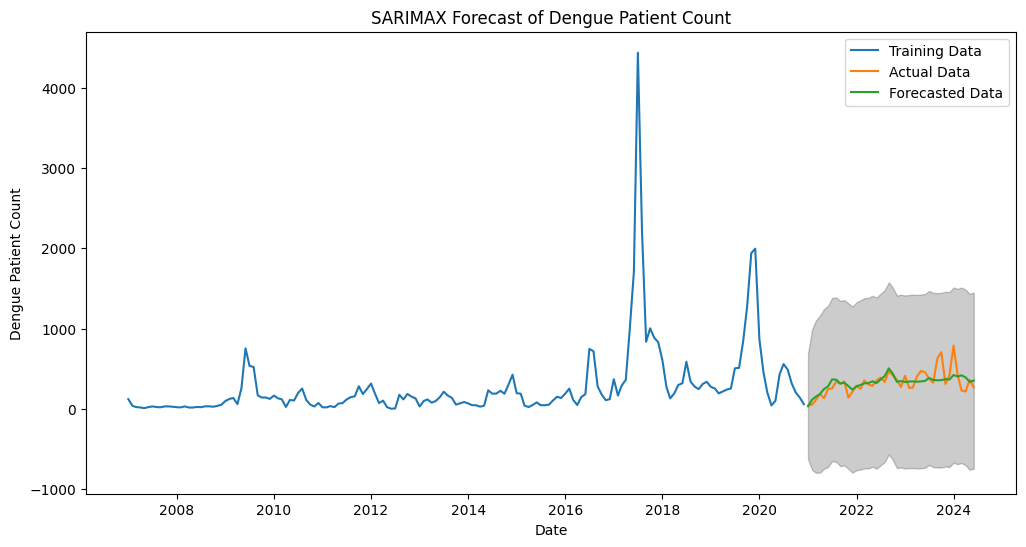

In [29]:
test_mse = mean_squared_error(test_data_2023['patients'], test_data_2023['Predicted'])
final_rmse = np.sqrt(test_mse)
print(f"RMSE for test dataset : {final_rmse}")

test_mse = mean_squared_error(test_data_2024['patients'], test_data_2024['Predicted'])
_rmse = np.sqrt(test_mse)
print(f"RMSE for 2024 dataset : {_rmse}")

# Plotting the results
plt.figure(figsize=(12, 6))

# plot the actual train dataset
plt.plot(train_data.index, train_data['patients'], label='Training Data')

# plot the test dataset and predictions
plt.plot(test_data.index, test_data['patients'], label='Actual Data')
plt.plot(test_data.index, testdata_forecast.predicted_mean, label='Forecasted Data')
plt.fill_between(test_data.index, final_forecast_ci.iloc[:, 0], final_forecast_ci.iloc[:, 1], color='k', alpha=0.2)


plt.xlabel('Date')
plt.ylabel('Dengue Patient Count')
plt.title('SARIMAX Forecast of Dengue Patient Count')
plt.legend()
plt.show()

In [30]:
# Merge the predictions back into the original DataFrame
original_df['Predicted'] = test_data['Predicted']

# Save the updated dataframe to CSV
original_df.to_csv('Kandy_df.csv')